In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

==============================linear-fstw
(50, 4, 4)


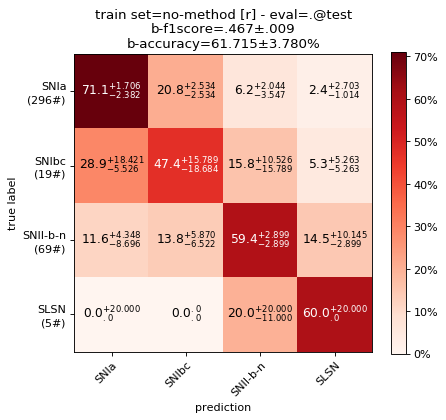

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.1630
[2#] SPM_t0_r=.1235
[3#] SPM_gamma_r=.1172
[4#] SPM_beta_r=.0851
[5#] SPM_tau_fall_r=.0784
[6#] SPM_tau_rise_r=.0764
[7#] SPM_tau_fall_g=.0663
[8#] SPM_gamma_g=.0643
[9#] SPM_tau_rise_g=.0448
[10#] SPM_beta_g=.0433
(50, 4, 4)


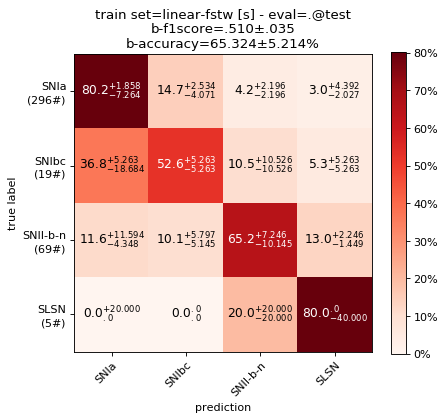

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2389
[2#] SPM_tau_rise_r=.0963
[3#] SPM_tau_fall_r=.0861
[4#] SPM_beta_r=.0798
[5#] SPM_gamma_r=.0713
[6#] SPM_t0_r=.0660
[7#] SPM_tau_fall_g=.0567
[8#] SPM_A_g=.0495
[9#] SPM_gamma_g=.0487
[10#] SPM_A_r=.0485
(50, 4, 4)


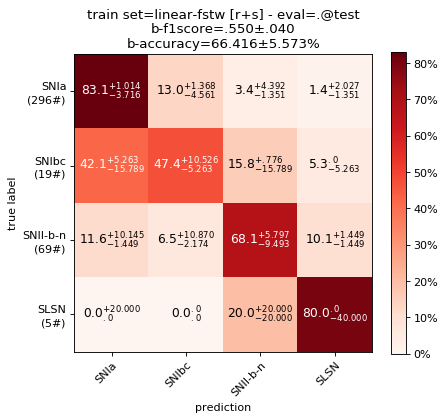

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2117
[2#] SPM_tau_fall_r=.0967
[3#] SPM_gamma_r=.0923
[4#] SPM_beta_r=.0908
[5#] SPM_t0_r=.0723
[6#] SPM_tau_rise_r=.0628
[7#] SPM_tau_fall_g=.0587
[8#] SPM_gamma_g=.0577
[9#] SPM_A_r=.0482
[10#] SPM_A_g=.0477
==============================bspline-fstw
(50, 4, 4)


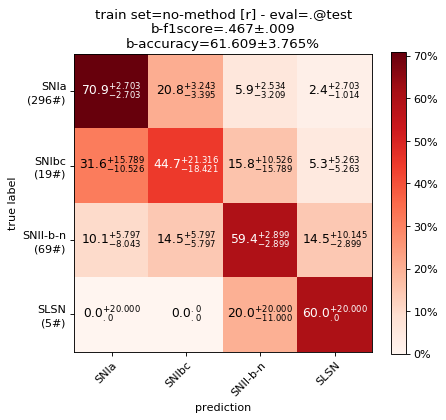

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.1631
[2#] SPM_gamma_r=.1193
[3#] SPM_t0_r=.1145
[4#] SPM_tau_fall_r=.0833
[5#] SPM_beta_r=.0797
[6#] SPM_tau_rise_r=.0752
[7#] SPM_tau_fall_g=.0677
[8#] SPM_gamma_g=.0638
[9#] SPM_beta_g=.0473
[10#] SPM_tau_rise_g=.0458
(50, 4, 4)


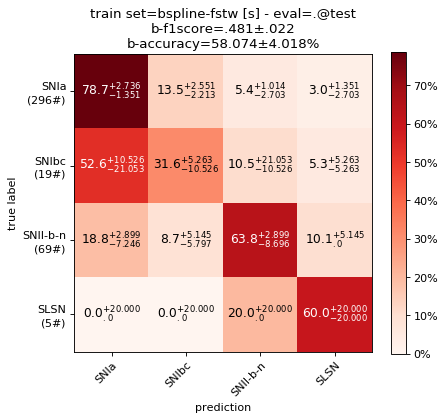

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2381
[2#] SPM_tau_rise_r=.1124
[3#] SPM_A_r=.0696
[4#] SPM_gamma_r=.0648
[5#] SPM_A_g=.0610
[6#] SPM_gamma_g=.0572
[7#] SPM_beta_r=.0552
[8#] SPM_tau_fall_r=.0535
[9#] SPM_chi_r=.0528
[10#] SPM_tau_rise_g=.0526
(50, 4, 4)


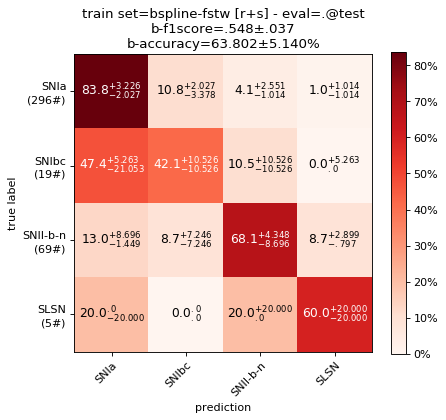

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2065
[2#] SPM_gamma_r=.0852
[3#] SPM_tau_rise_r=.0800
[4#] SPM_beta_r=.0742
[5#] SPM_t0_r=.0708
[6#] SPM_gamma_g=.0700
[7#] SPM_tau_fall_r=.0667
[8#] SPM_tau_fall_g=.0636
[9#] SPM_A_r=.0586
[10#] SPM_A_g=.0547
==============================spm-mcmc-fstw
(50, 4, 4)


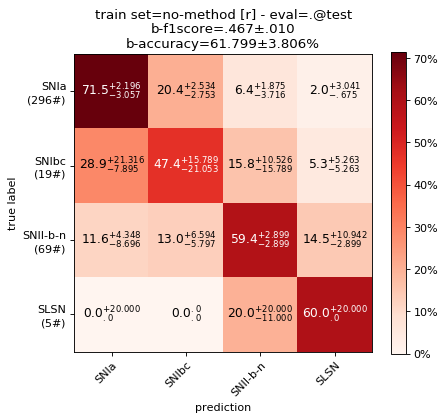

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.1644
[2#] SPM_t0_r=.1217
[3#] SPM_gamma_r=.1166
[4#] SPM_beta_r=.0849
[5#] SPM_tau_fall_r=.0810
[6#] SPM_tau_rise_r=.0736
[7#] SPM_tau_fall_g=.0678
[8#] SPM_gamma_g=.0589
[9#] SPM_beta_g=.0481
[10#] SPM_tau_rise_g=.0458
(50, 4, 4)


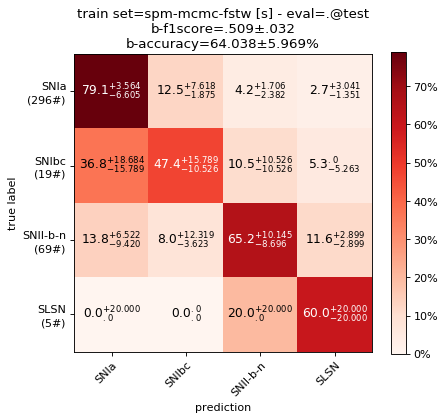

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2208
[2#] SPM_gamma_r=.1020
[3#] SPM_beta_r=.0895
[4#] SPM_tau_fall_r=.0861
[5#] SPM_tau_rise_r=.0702
[6#] SPM_t0_r=.0644
[7#] SPM_A_r=.0559
[8#] SPM_tau_fall_g=.0542
[9#] SPM_A_g=.0538
[10#] SPM_gamma_g=.0509
(50, 4, 4)


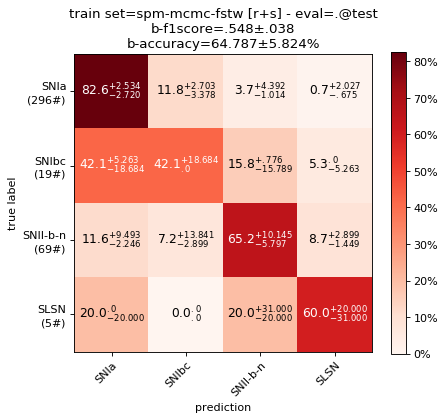

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2102
[2#] SPM_gamma_r=.1047
[3#] SPM_beta_r=.0965
[4#] SPM_tau_fall_r=.0926
[5#] SPM_t0_r=.0662
[6#] SPM_tau_rise_r=.0576
[7#] SPM_gamma_g=.0561
[8#] SPM_tau_fall_g=.0558
[9#] SPM_A_r=.0526
[10#] SPM_A_g=.0508
==============================spm-mcmc-estw
(50, 4, 4)


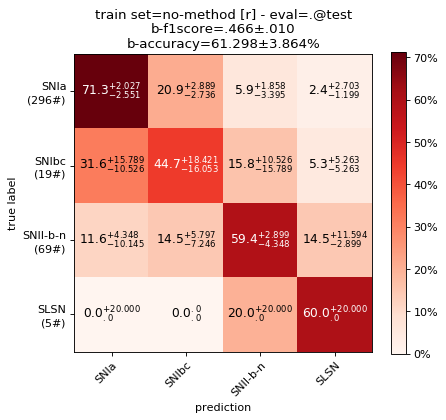

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.1680
[2#] SPM_t0_r=.1159
[3#] SPM_gamma_r=.1139
[4#] SPM_tau_fall_r=.0809
[5#] SPM_beta_r=.0801
[6#] SPM_tau_rise_r=.0788
[7#] SPM_tau_fall_g=.0650
[8#] SPM_gamma_g=.0631
[9#] SPM_beta_g=.0493
[10#] SPM_tau_rise_g=.0442
(50, 4, 4)


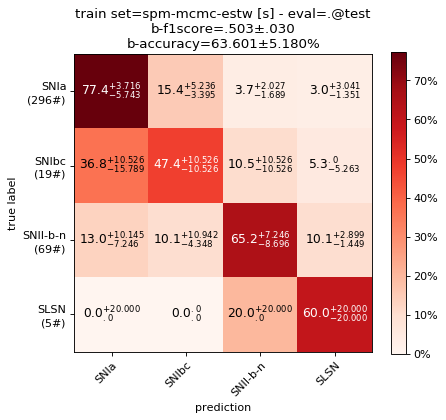

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2357
[2#] SPM_beta_r=.0956
[3#] SPM_tau_fall_r=.0940
[4#] SPM_tau_rise_r=.0875
[5#] SPM_gamma_r=.0807
[6#] SPM_A_r=.0622
[7#] SPM_A_g=.0526
[8#] SPM_tau_fall_g=.0517
[9#] SPM_t0_r=.0487
[10#] SPM_gamma_g=.0442
(50, 4, 4)


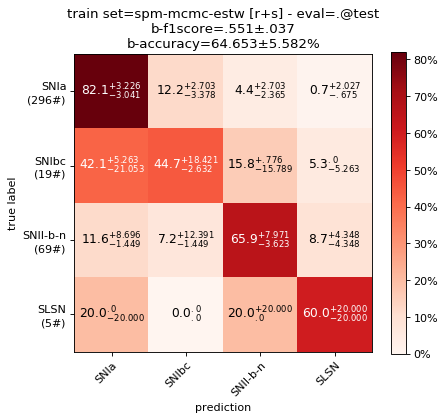

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.2241
[2#] SPM_beta_r=.0990
[3#] SPM_gamma_r=.0944
[4#] SPM_tau_fall_r=.0915
[5#] SPM_tau_rise_r=.0648
[6#] SPM_A_r=.0622
[7#] SPM_tau_fall_g=.0559
[8#] SPM_t0_r=.0514
[9#] SPM_gamma_g=.0505
[10#] SPM_A_g=.0483


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

mode = 'all' # all sne
methods = [
    'linear-fstw',
    'bspline-fstw',
    #'spm-mle-fstw',
    'spm-mcmc-fstw',
    #'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test' # val test
kf = '.'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        f1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])
        accuracy_xe = XError([f()['metrics_dict']['b-accuracy'] for f in files])
        print(cms.shape)

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'train set={_title} - eval={kf}@{eval_lcset_name}'+'\n'
        title += f'b-f1score={f1score_xe}'+'\n'
        title += f'b-accuracy={accuracy_xe}%'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #print(files[0]()['features'])
        plt.show()
        print(class_names)
        print(files[0]()['rank'])
        df = files[0]()['wrongs_df']
        #display(df[df['_y']==0])
        #display(df[df['_y']==2])

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

metrics = [
    'b-accuracy',
    'b-f1score',
    'b-gmean',
    #'b-dpower',
    'b-xentropy',
]
info_df = DFBuilder()
for metric in metrics:
    for train_config in ['r', 's', 'r+s']:
    #for train_config in ['r', 's']:
        d = {}
        for method in methods:
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            metric_xe = XError([f()['metrics_dict'][metric] for f in files])
            d[method] = metric_xe
            #print(len(metric_xe))

        info_df.append(f'metric={metric} [{train_config}]', d)
        
latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|ccc|c}
\hline
metric & linear-fstw & bspline-fstw & spm-mcmc-fstw & spm-mcmc-estw \srule\\\hline\hline
b-accuracy [r] & 61.715$\pm$3.780 & 61.609$\pm$3.765 & 61.799$\pm$3.806 & 61.298$\pm$3.864  \srule\\
b-accuracy [s] & 65.324$\pm$5.214 & 58.074$\pm$4.018 & 64.038$\pm$5.969 & 63.601$\pm$5.180  \srule\\
b-accuracy [r+s] & 66.416$\pm$5.573 & 63.802$\pm$5.140 & 64.787$\pm$5.824 & 64.653$\pm$5.582  \srule\\
\hline
b-f1score [r] & .467$\pm$.009 & .467$\pm$.009 & .467$\pm$.010 & .466$\pm$.010  \srule\\
b-f1score [s] & .510$\pm$.035 & .481$\pm$.022 & .509$\pm$.032 & .503$\pm$.030  \srule\\
b-f1score [r+s] & .550$\pm$.040 & .548$\pm$.037 & .548$\pm$.038 & .551$\pm$.03

,linear-fstw,bspline-fstw,spm-mcmc-fstw,spm-mcmc-estw
metric=b-accuracy [r],61.715±3.780,61.609±3.765,61.799±3.806,61.298±3.864
metric=b-accuracy [s],65.324±5.214,58.074±4.018,64.038±5.969,63.601±5.180
metric=b-accuracy [r+s],66.416±5.573,63.802±5.140,64.787±5.824,64.653±5.582
metric=b-f1score [r],.467±.009,.467±.009,.467±.010,.466±.010
metric=b-f1score [s],.510±.035,.481±.022,.509±.032,.503±.030
metric=b-f1score [r+s],.550±.040,.548±.037,.548±.038,.551±.037
metric=b-gmean [r],.735±.027,.735±.026,.736±.027,.733±.027
metric=b-gmean [s],.761±.038,.703±.031,.752±.043,.749±.037
metric=b-gmean [r+s],.768±.040,.750±.038,.757±.042,.757±.040
metric=b-xentropy [r],.948±.051,.948±.051,.947±.051,.947±.051


In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        rank = files[0]()['rank']
        #print(rank)
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.3f}%)'

    info_df.append(f'rank={k+1}', d)

latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|ccc|c}
\hline
rank & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (21.170\%) & SPM-t0-g (20.657\%) & SPM-t0-g (21.021\%) & SPM-t0-g (22.413\%)  \srule\\
2 & SPM-tau-fall-r (9.671\%) & SPM-gamma-r (8.524\%) & SPM-gamma-r (10.471\%) & SPM-beta-r (9.903\%)  \srule\\
3 & SPM-gamma-r (9.233\%) & SPM-tau-rise-r (8.009\%) & SPM-beta-r (9.655\%) & SPM-gamma-r (9.446\%)  \srule\\
4 & SPM-beta-r (9.088\%) & SPM-beta-r (7.425\%) & SPM-tau-fall-r (9.261\%) & SPM-tau-fall-r (9.153\%)  \srule\\
5 & SPM-t0-r (7.237\%) & SPM-t0-r (7.084\%) & SPM-t0-r (6.628\%) & SPM-tau-rise-r (6.486\%)  \srule\\
6 & SPM-t

,linear-fstw [r+s],bspline-fstw [r+s],spm-mcmc-fstw [r+s],spm-mcmc-estw [r+s]
rank=1,SPM-t0-g (21.170%),SPM-t0-g (20.657%),SPM-t0-g (21.021%),SPM-t0-g (22.413%)
rank=2,SPM-tau-fall-r (9.671%),SPM-gamma-r (8.524%),SPM-gamma-r (10.471%),SPM-beta-r (9.903%)
rank=3,SPM-gamma-r (9.233%),SPM-tau-rise-r (8.009%),SPM-beta-r (9.655%),SPM-gamma-r (9.446%)
rank=4,SPM-beta-r (9.088%),SPM-beta-r (7.425%),SPM-tau-fall-r (9.261%),SPM-tau-fall-r (9.153%)
rank=5,SPM-t0-r (7.237%),SPM-t0-r (7.084%),SPM-t0-r (6.628%),SPM-tau-rise-r (6.486%)
rank=6,SPM-tau-rise-r (6.284%),SPM-gamma-g (7.002%),SPM-tau-rise-r (5.765%),SPM-A-r (6.221%)
rank=7,SPM-tau-fall-g (5.870%),SPM-tau-fall-r (6.671%),SPM-gamma-g (5.619%),SPM-tau-fall-g (5.591%)
rank=8,SPM-gamma-g (5.777%),SPM-tau-fall-g (6.362%),SPM-tau-fall-g (5.581%),SPM-t0-r (5.142%)
rank=9,SPM-A-r (4.823%),SPM-A-r (5.864%),SPM-A-r (5.263%),SPM-gamma-g (5.054%)
rank=10,SPM-A-g (4.772%),SPM-A-g (5.471%),SPM-A-g (5.083%),SPM-A-g (4.836%)
